# Testing and Evaluating Options Pricing Models

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## Load the Libs we need

In [1]:
# Import libraries
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Import sklearn modules
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm

## Introduction to Testing and Evaluating Trading Models

In [2]:
# Mock data
past_prices = np.array([100, 105, 103, 108, 107]).reshape(-1, 1)
option_prices = np.array([5, 4.5, 5.2, 4.8, 4.7])

# Split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(past_prices, option_prices, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression().fit(X_train, y_train)

# Evaluate the model's performance using Mean Absolute Error (MAE)
predicted = model.predict(X_test)
mae = mean_absolute_error(y_test, predicted)

print(f"Mean Absolute Error: {mae:.2f}")

Mean Absolute Error: 0.40


## Performance Metrics for Trading Models

In [3]:
# Define the Sharpe Ratio function
def mb_sharpe_ratio(returns, risk_free_rate=0.01):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

# Define the Sortino Ratio function
def mb_sortino_ratio(returns, risk_free_rate=0.01, target_return=0):
    excess_returns = returns - risk_free_rate
    downside_std = np.std(np.clip(excess_returns - target_return, None, 0))
    return np.mean(excess_returns) / downside_std

# Define the Maximum Drawdown function
def mb_max_drawdown(returns):
    cumulative_returns = np.cumprod(1 + returns)
    max_return = np.fmax.accumulate(cumulative_returns)
    return np.min(cumulative_returns / max_return - 1)

# Sample returns data
returns = np.array([0.08, 0.12, -0.05, 0.10, -0.03, 0.15, 0.07, -0.06, 0.04, -0.10])

# Print the metrics
print(f"Sharpe Ratio: {mb_sharpe_ratio(returns):.2f}")
print(f"Sortino Ratio: {mb_sortino_ratio(returns):.2f}")
print(f"Maximum Drawdown: {mb_max_drawdown(returns):.2f}")



Sharpe Ratio: 0.27
Sortino Ratio: 0.58
Maximum Drawdown: -0.12


## Backtesting Techniques

In [4]:
new_past_prices = np.array([106, 104, 107, 109, 108]).reshape(-1, 1)
predicted_option_prices = model.predict(new_past_prices)
print(predicted_option_prices)

[4.86097561 4.94634146 4.81829268 4.73292683 4.77560976]


In [5]:
def mb_rolling_window_backtest(data, window_size):
    signals = []
    for start in range(0, len(data) - window_size):
        end = start + window_size
        window_data = data[start:end]
        moving_avg = np.mean(window_data)
        if window_data[-1] > moving_avg:
            signals.append('buy')
        else:
            signals.append('sell')
    return signals

data = np.array([100, 102, 99, 105, 104, 103, 108, 107])
signals = mb_rolling_window_backtest(data, window_size=3)
print(signals)


['sell', 'buy', 'buy', 'sell', 'buy']


## Model Validation Approaches

In [6]:
# Generate a larger mock dataset
np.random.seed(42)  # for reproducibility

# Creating a sequence of 500 numbers as past prices
past_prices = np.linspace(50, 150, 500) 

# Generating option prices with a linear relationship + some random noise
option_prices = 0.1 * past_prices + 5 + np.random.normal(0, 2, 500)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(past_prices.reshape(-1, 1), option_prices, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression().fit(X_train, y_train)

# Predict using the test set
predictions = model.predict(X_test)

# Calculate R^2 score
accuracy = r2_score(y_test, predictions)

print(f"Model R^2 Score: {accuracy:.2f}")

Model R^2 Score: 0.73


In [7]:
# Reshape the data to ensure it's in the expected 2D format
X = past_prices.reshape(-1, 1)
y = option_prices

# Perform cross-validation
scores = cross_val_score(LinearRegression(), X, y, cv=5)
print(f"Cross-validation Scores: {scores}")
print(f"Average Score: {np.mean(scores):.2f}")

Cross-validation Scores: [0.07126362 0.08633118 0.01805444 0.0756227  0.00986164]
Average Score: 0.05


In [8]:
# Generate new data points that the model hasn't seen and ensure it's reshaped
new_data = np.array([110, 111, 113, 112, 115, 116, 118, 117, 119, 120]).reshape(-1, 1)

# Use the model (which was trained on past_prices) to predict option prices for the new data
predicted_prices = model.predict(new_data)
print(predicted_prices)

[16.02148275 16.12297715 16.32596595 16.22447155 16.52895475 16.63044916
 16.83343796 16.73194356 16.93493236 17.03642676]


## Addressing Overfitting and Improving Model Performance

In [9]:
# Using Lasso regression, that includes a penalty term which can help in reducing overfitting.
lasso_model = Lasso(alpha=0.1).fit(X_train, y_train)
predictions = lasso_model.predict(X_test)

accuracy = lasso_model.score(X_test, y_test)
print(f"Lasso Model Accuracy: {accuracy:.2f}")

Lasso Model Accuracy: 0.73


In [10]:
# Using Ridge regression to reduce overfitting.
ridge_model = Ridge(alpha=0.5).fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)

accuracy = ridge_model.score(X_test, y_test)
print(f"Ridge Model Accuracy: {accuracy:.2f}")

Ridge Model Accuracy: 0.73


In [11]:
# Using Random Forests, which are less prone to overfitting compared to simple linear models.
rf_model = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

accuracy = rf_model.score(X_test, y_test)
print(f"Random Forest Model Accuracy: {accuracy:.2f}")

Random Forest Model Accuracy: 0.65


## Option Pricing Model Validation

#### Calibration of a Black-Scholes Model

In [12]:
# Black-Scholes formula for European Call Option
def mb_black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Calibration function
def mb_calibration_function(params, S, K, T, r, market_prices):
    sigma = params[0]
    model_prices = mb_black_scholes_call(S, K, T, r, sigma)
    error = np.sum((market_prices - model_prices)**2)
    return error

# Market data
S = 100  # Current stock price
K = np.array([90, 95, 100, 105, 110])  # Strike prices
T = 1  # Time to maturity
r = 0.05  # Risk-free rate
market_prices = np.array([12, 10, 8, 6, 4])  # Market prices of the call options

# Initial guess for volatility
initial_guess = [0.2]

# Calibrate the model
result = opt.minimize(mb_calibration_function, initial_guess, args=(S, K, T, r, market_prices))
calibrated_sigma = result.x[0]
print(f"Calibrated Volatility: {calibrated_sigma:.4f}")

# Validate the model
model_prices = mb_black_scholes_call(S, K, T, r, calibrated_sigma)
print(f"Model Prices: {model_prices}")


Calibrated Volatility: 0.1257
Model Prices: [14.99475112 11.05385999  7.7097394   5.06999405  3.13988127]


#### Out-of-Sample Testing

In [13]:
# New market data for out-of-sample testing
new_market_prices = np.array([13, 11, 9, 7, 5])
new_strike_prices = np.array([85, 90, 95, 100, 105])

# Using the calibrated model to predict new prices
new_model_prices = mb_black_scholes_call(S, new_strike_prices, T, r, calibrated_sigma)
print(f"New Model Prices: {new_model_prices}")

# Performance metrics for out-of-sample data
mae_out_sample = np.mean(np.abs(new_market_prices - new_model_prices))
rmse_out_sample = np.sqrt(np.mean((new_market_prices - new_model_prices)**2))
print(f"Out-of-Sample Mean Absolute Error: {mae_out_sample:.4f}")
print(f"Out-of-Sample Root Mean Squared Error: {rmse_out_sample:.4f}")


New Model Prices: [19.35683001 14.99475112 11.05385999  7.7097394   5.06999405]
Out-of-Sample Mean Absolute Error: 2.6370
Out-of-Sample Root Mean Squared Error: 3.4955


#### Calculating Performance Metrics

In [14]:
# Assuming model_prices and market_prices are available
mae = mean_absolute_error(market_prices, model_prices)
rmse = np.sqrt(mean_squared_error(market_prices, model_prices))
r2 = r2_score(market_prices, model_prices)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")


Mean Absolute Error: 1.2258
Root Mean Squared Error: 1.5342
R-squared: 0.7058


#### Scenario Analysis

In [15]:
# Different market scenarios
scenarios = [
    {'S': 100, 'K': 100, 'T': 1, 'r': 0.05, 'sigma': 0.2},
    {'S': 120, 'K': 100, 'T': 0.5, 'r': 0.03, 'sigma': 0.25},
    {'S': 80, 'K': 90, 'T': 2, 'r': 0.07, 'sigma': 0.3}
]

for i, scenario in enumerate(scenarios):
    price = mb_black_scholes_call(scenario['S'], scenario['K'], scenario['T'], scenario['r'], scenario['sigma'])
    print(f"Scenario {i+1} - Call Price: {price:.2f}")


Scenario 1 - Call Price: 10.45
Scenario 2 - Call Price: 22.76
Scenario 3 - Call Price: 14.19


#### Sensitivity Analysis

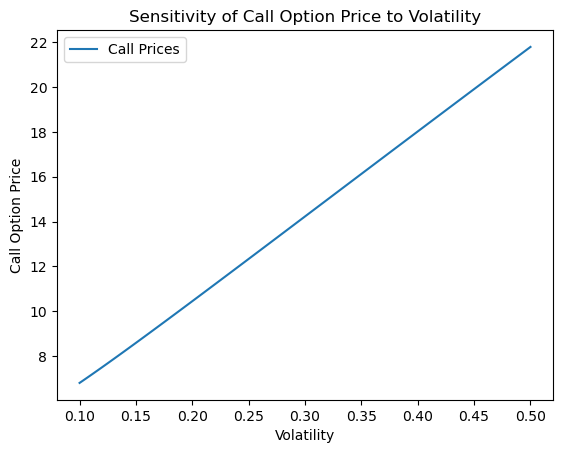

In [16]:
# Sensitivity analysis for volatility
volatilities = np.linspace(0.1, 0.5, 100)
call_prices = [mb_black_scholes_call(S, 100, T, r, vol) for vol in volatilities]

plt.plot(volatilities, call_prices, label='Call Prices')
plt.xlabel('Volatility')
plt.ylabel('Call Option Price')
plt.title('Sensitivity of Call Option Price to Volatility')
plt.legend()
plt.show()


#### Calculating and Testing the Greeks

In [17]:
# Delta: Sensitivity to underlying asset price
def mb_delta(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

# Gamma: Sensitivity to Delta
def mb_gamma(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.pdf(d1) / (S * sigma * np.sqrt(T))

# Theta: Sensitivity to time
def mb_theta(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    term1 = -(S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))
    term2 = r * K * np.exp(-r * T) * norm.cdf(d2)
    return term1 - term2

# Vega: Sensitivity to volatility
def mb_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

# Rho: Sensitivity to interest rate
def mb_rho(S, K, T, r, sigma):
    d2 = (np.log(S / K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return K * T * np.exp(-r * T) * norm.cdf(d2)

# Example calculations for a single option
S = 100  # Current stock price
K = 100  # Strike price
T = 1  # Time to maturity
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility

delta_value = mb_delta(S, K, T, r, sigma)
gamma_value = mb_gamma(S, K, T, r, sigma)
theta_value = mb_theta(S, K, T, r, sigma)
vega_value = mb_vega(S, K, T, r, sigma)
rho_value = mb_rho(S, K, T, r, sigma)

print(f"Delta: {delta_value:.4f}")
print(f"Gamma: {gamma_value:.4f}")
print(f"Theta: {theta_value:.4f}")
print(f"Vega: {vega_value:.4f}")
print(f"Rho: {rho_value:.4f}")


Delta: 0.6368
Gamma: 0.0188
Theta: -6.4140
Vega: 37.5240
Rho: 53.2325
